In [2]:
import os
import pickle
import sys
import warnings
from glob import glob

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#import shap
import xgboost
from scipy.stats import spearmanr
from sklearn.ensemble import (
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.metrics import accuracy_score, mean_squared_error
from tqdm.auto import tqdm


# 表示用の設定を変更します
%matplotlib inline
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.width = 120

In [3]:
dataset_dir="/Users/chubachikoya/competition/stockprice/stock"

In [4]:
inputs = {
    "stock_list": f"{dataset_dir}/stock_list.csv.gz",
    "stock_price": f"{dataset_dir}/stock_price.csv.gz",
    "stock_fin": f"{dataset_dir}/stock_fin.csv.gz",
    "stock_labels": f"{dataset_dir}/stock_labels.csv.gz",
}

In [6]:
dfs = {}
for k, v in inputs.items():
    print(k)
    dfs[k] = pd.read_csv(v)
    if k == "stock_price":
        dfs[k].loc[:, "datetime"] = pd.to_datetime(
            dfs[k].loc[:, "EndOfDayQuote Date"]
        )
        dfs[k].set_index("datetime", inplace=True)
    elif k in ["stock_fin", "stock_fin_price", "stock_labels"]:
        dfs[k].loc[:, "datetime"] = pd.to_datetime(
            dfs[k].loc[:, "base_date"]
        )
        dfs[k].set_index("datetime", inplace=True)

stock_list
stock_price
stock_fin
stock_labels


In [10]:
dfs['stock_price'].head(2)

Local Code EndOfDayQuote Date  EndOfDayQuote Open  EndOfDayQuote High  EndOfDayQuote Low  \
datetime                                                                                               
2016-01-04        1301         2016/01/04              2800.0              2820.0             2740.0   
2016-01-05        1301         2016/01/05              2750.0              2780.0             2750.0   

            EndOfDayQuote Close  EndOfDayQuote ExchangeOfficialClose  EndOfDayQuote Volume  \
datetime                                                                                     
2016-01-04               2750.0                               2750.0               32000.0   
2016-01-05               2760.0                               2760.0               20100.0   

            EndOfDayQuote CumulativeAdjustmentFactor  EndOfDayQuote PreviousClose EndOfDayQuote PreviousCloseDate  \
datetime                                                                                                            
2016-01-04                                       0.1                       2770.0                      2015/12/30   
2016-01-05                                       0.1                       2750.0                      2016/01/04   

            EndOfDayQuote PreviousExchangeOfficialClose EndOfDayQuote PreviousExchangeOfficialCloseDate  \
datetime                                                                                                  
2016-01-04                                       2770.0                                      2015/12/30   
2016-01-05                                       2750.0                                      2016/01/04   

            EndOfDayQuote ChangeFromPreviousClose  EndOfDayQuote PercentChangeFromPreviousClose  EndOfDayQuote VWAP  
datetime                                                                                                             
2016-01-04                                  -20.0                                        -0.722             2778.25  
2016-01-05                                   10.0                                         0.364             2761.99

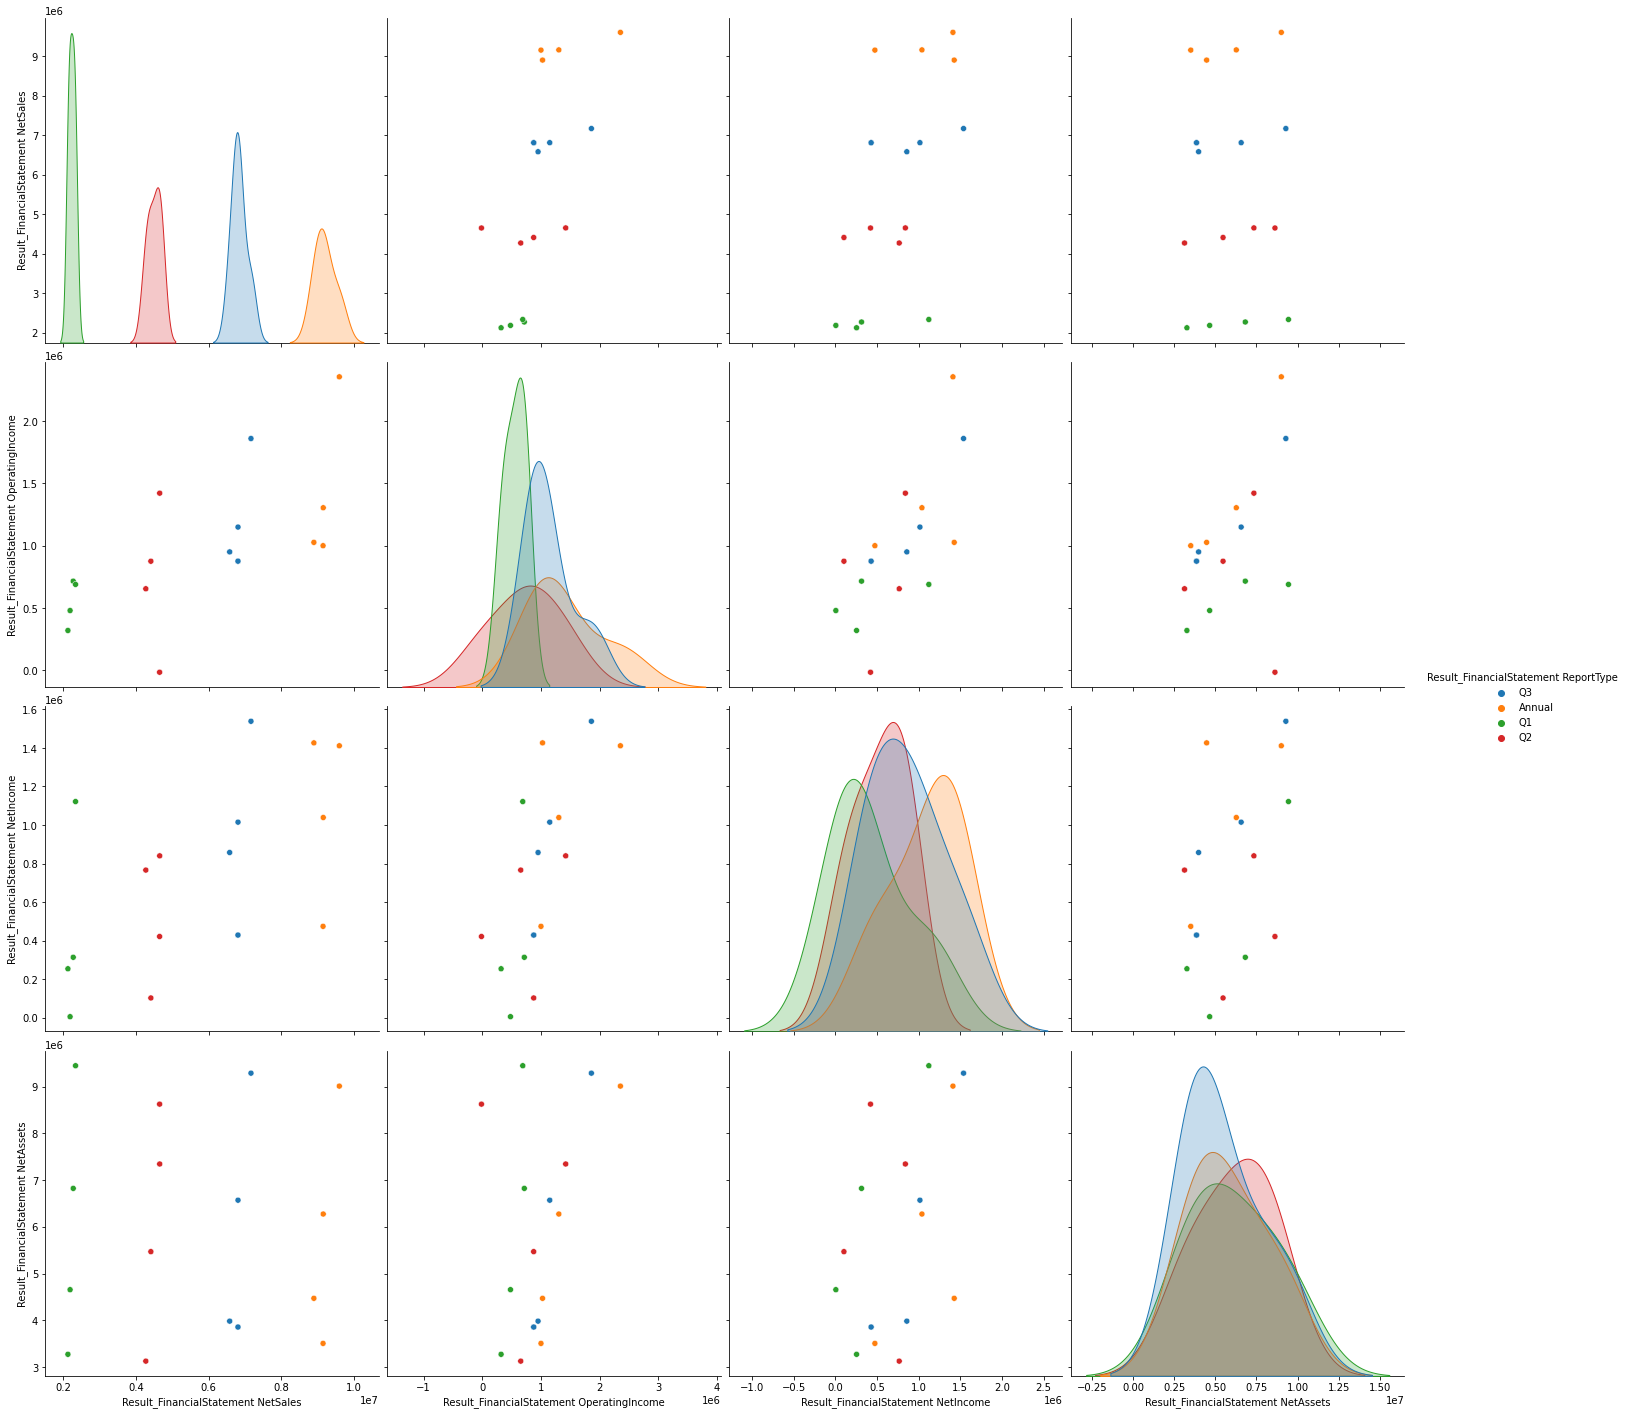

In [12]:
fin = dfs["stock_fin"]

code = 9984
fin_data = fin[fin["Local Code"]==code]

fin_data = fin_data[:'2019']

columns = [
    "Result_FinancialStatement NetSales",  # 売上高
    "Result_FinancialStatement OperatingIncome",  # 営業利益
    "Result_FinancialStatement NetIncome",  # 純利益
    "Result_FinancialStatement NetAssets",  # 純資産
    "Result_FinancialStatement ReportType"  # 決算期
]

sns.pairplot(fin_data[columns],
            hue="Result_FinancialStatement ReportType",height=5)

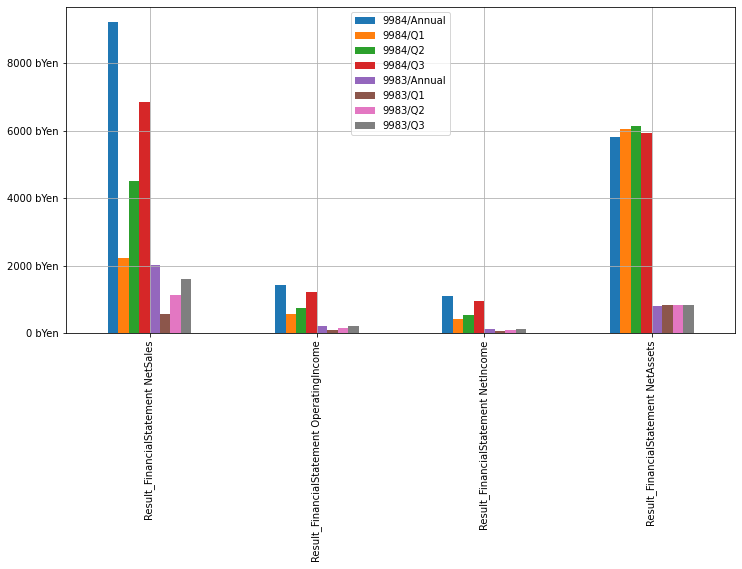

In [16]:
fin = dfs["stock_fin"]

codes = [9984, 9983]

multi_df = dict()

columns = [
    "Result_FinancialStatement NetSales",  # 売上高
    "Result_FinancialStatement OperatingIncome",  # 営業利益
    "Result_FinancialStatement NetIncome",  # 純利益
    "Result_FinancialStatement NetAssets",  # 純資産
    "Result_FinancialStatement ReportType"  # 決算期
]

for code in codes:
    fin_data = fin[fin["Local Code"] == code]
    fin_data = fin_data[:"2019"].copy()
    fin_data.drop_duplicates(
        subset=[
            "Local Code",
            "Result_FinancialStatement FiscalYear",
            "Result_FinancialStatement ReportType"
        ],
        keep="last", inplace=True)
    _fin_data = fin_data[columns]
    multi_df[code] = _fin_data[columns].groupby("Result_FinancialStatement ReportType").mean()


multi_df = pd.concat(multi_df)
multi_df.set_index(multi_df.index.map(lambda t: f"{t[0]}/{t[1]}"), inplace=True)
ax = multi_df.T.plot(kind="bar", figsize=(12, 6), grid=True)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: "{} bYen".format(int(x / 1_000))))

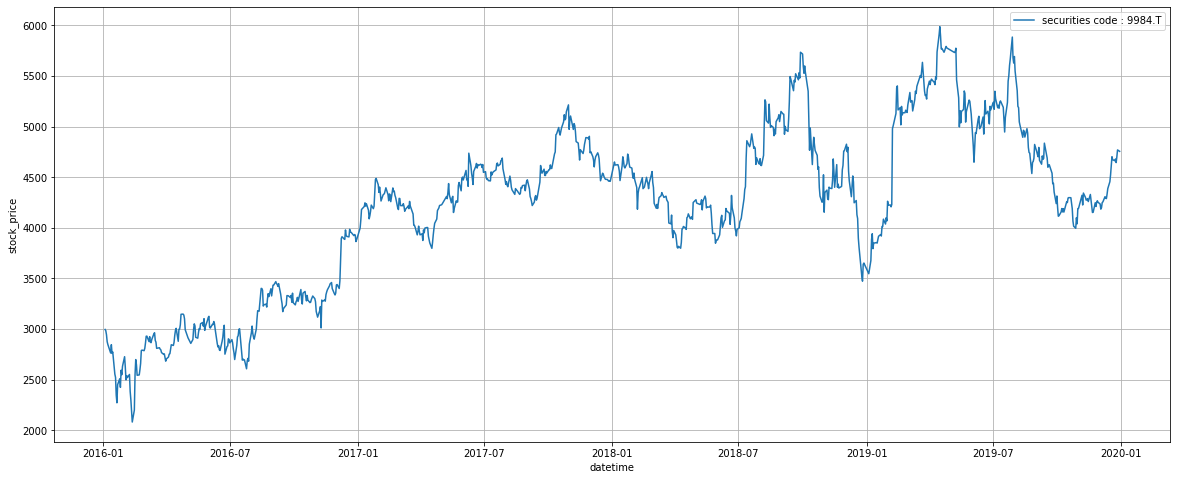

In [21]:
price = dfs["stock_price"]

code = 9984
price_data = price[price["Local Code"]==code]
price_data = price_data[:"2019"]

fig,ax = plt.subplots(figsize=(20,8))

ax.plot(price_data["EndOfDayQuote ExchangeOfficialClose"],label=f"securities code : {code}.T")
ax.set_ylabel("stock_price")
ax.set_xlabel("datetime")
ax.grid(True)
ax.legend()

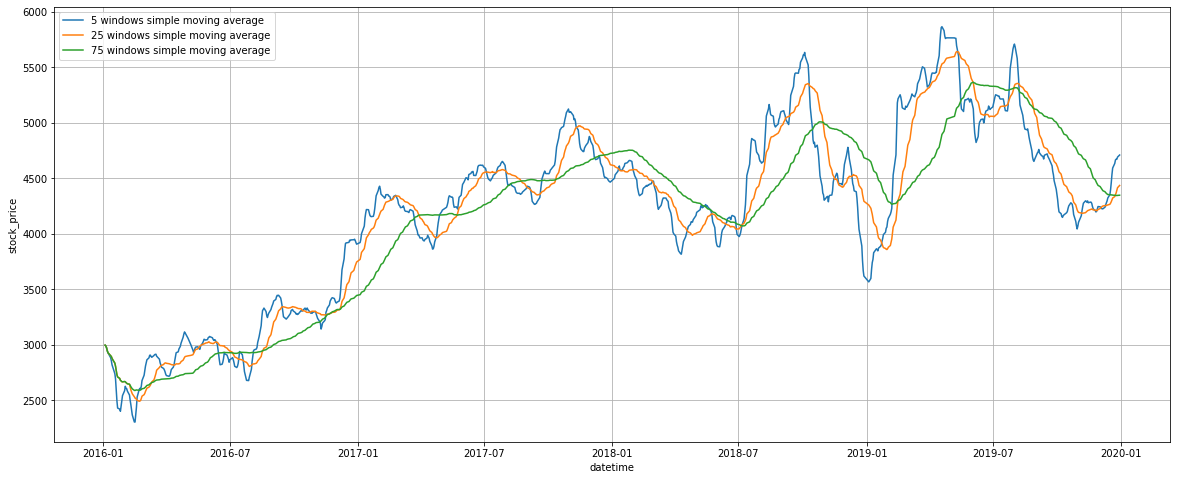

In [31]:
price = dfs["stock_price"]

code = 9984
price_data = price[price["Local Code"]==code]
price_data = price_data[:"2019"].copy()

periods = [5,25,75]
cols = []
for period in periods:
    col = "{} windows simple moving average".format(period)
    price_data[col] = price_data["EndOfDayQuote ExchangeOfficialClose"].rolling(period, min_periods=1).mean()
    cols.append(col)

fig,ax = plt.subplots(figsize=(20,8))

for col in cols:
    ax.plot(price_data[col],label=col)
ax.set_ylabel("stock_price")
ax.set_xlabel("datetime")
ax.grid(True)
ax.legend();

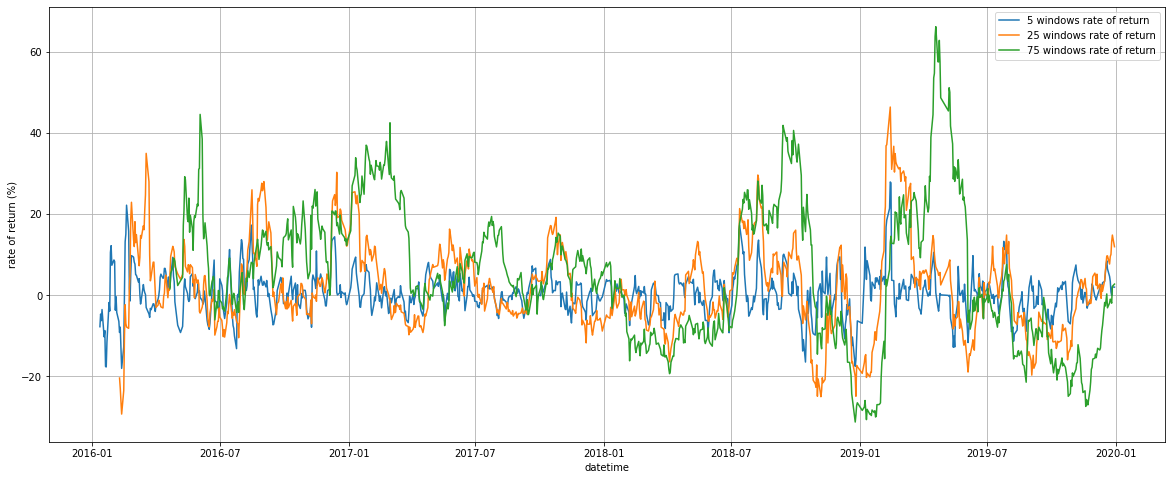

In [36]:
price = dfs["stock_price"]

code = 9984
price_data = price[price["Local Code"]==code]
price_data = price_data[:"2019"].copy()

periods = [5,25,75]
cols = []
for period in periods:
    col = "{} windows rate of return".format(period)
    price_data[col] = price_data["EndOfDayQuote ExchangeOfficialClose"].pct_change(period) * 100
    cols.append(col)

fig,ax = plt.subplots(figsize=(20,8))

for col in cols:
    ax.plot(price_data[col],label=col)
ax.set_ylabel("rate of return (%)")
ax.set_xlabel("datetime")
ax.grid(True)
ax.legend();

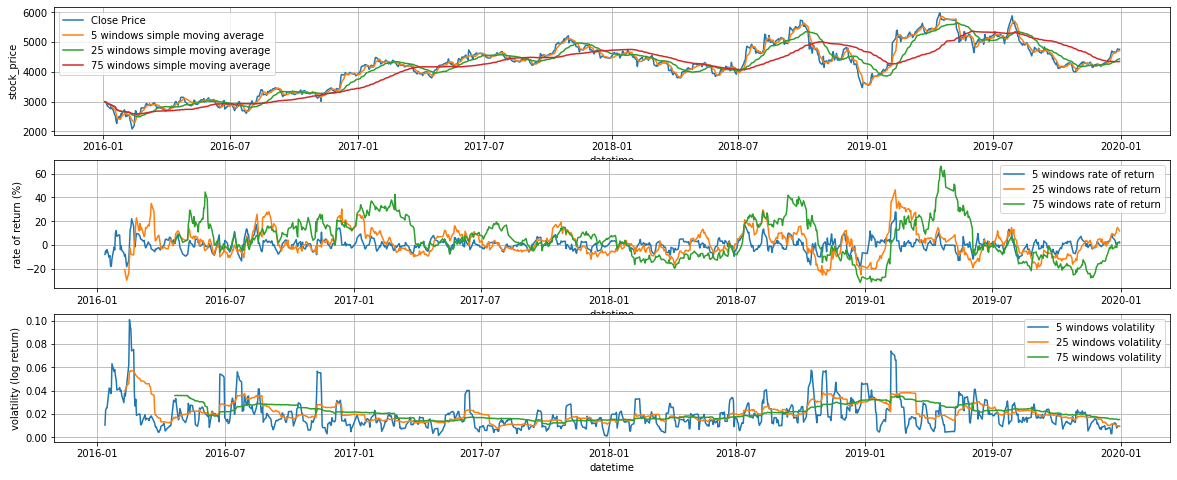

In [37]:
# stock_priceの読み込み
price = dfs["stock_price"]

# 特定の銘柄コードに絞り込み
code = 9984
price_data = price[price["Local Code"] == code]
# 2019年までの値を表示
price_data = price_data[:"2019"].copy()

# 5日、25日、75日を対象に値を算出
periods = [5, 25, 75]
ma_cols = []
# 移動平均線
for period in periods:
    col = "{} windows simple moving average".format(period)
    price_data[col] = price_data["EndOfDayQuote ExchangeOfficialClose"].rolling(period, min_periods=1).mean()
    ma_cols.append(col)

return_cols = []
# 価格変化率
for period in periods:
    col = "{} windows rate of return".format(period)
    price_data[col] = price_data["EndOfDayQuote ExchangeOfficialClose"].pct_change(period) * 100
    return_cols.append(col)

vol_cols = []
# ヒストリカル・ボラティリティ
for period in periods:
    col = "{} windows volatility".format(period)
    price_data[col] = np.log(price_data["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(period).std()
    vol_cols.append(col)

# プロット
fig, ax = plt.subplots(nrows=3 ,figsize=(20, 8))

ax[0].plot(price_data["EndOfDayQuote ExchangeOfficialClose"], label="Close Price")

for col in ma_cols:
    ax[0].plot(price_data[col], label=col)

for col in return_cols:
    ax[1].plot(price_data[col], label=col)

for col in vol_cols:
    ax[2].plot(price_data[col], label=col)

ax[0].set_ylabel("stock_price")
ax[1].set_ylabel("rate of return (%)")
ax[2].set_ylabel("volatility (log return)")
for _ax in ax:
    _ax.set_xlabel("datetime")
    _ax.grid(True)
    _ax.legend()

(64421, 44)
base_date                                                         0
Local Code                                                        0
Result_FinancialStatement AccountingStandard                    239
Result_FinancialStatement FiscalPeriodEnd                       239
Result_FinancialStatement ReportType                            239
Result_FinancialStatement FiscalYear                            239
Result_FinancialStatement ModifyDate                            239
Result_FinancialStatement CompanyType                           239
Result_FinancialStatement ChangeOfFiscalYearEnd                 239
Result_FinancialStatement NetSales                              256
Result_FinancialStatement OperatingIncome                      2072
Result_FinancialStatement OrdinaryIncome                        308
Result_FinancialStatement NetIncome                             242
Result_FinancialStatement TotalAssets                           240
Result_FinancialStatement NetAssets 

<AxesSubplot:ylabel='year'>

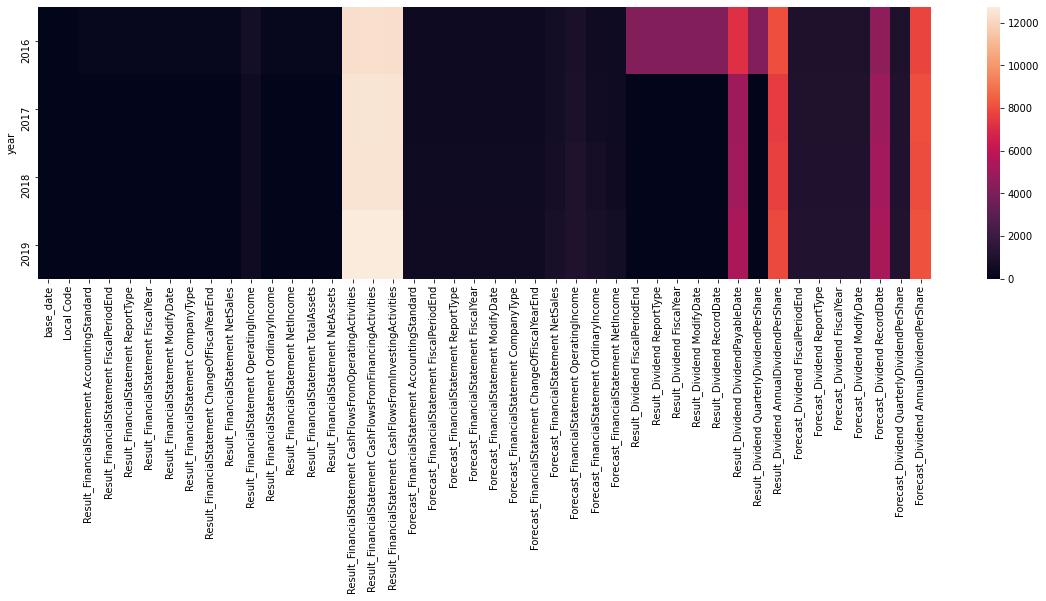

In [39]:
stock_fin = dfs["stock_fin"]
stock_fin = stock_fin[:"2019"]

print(stock_fin.shape)
print(stock_fin.isna().sum())

stock_fin = stock_fin.isna()
stock_fin["year"] = stock_fin.index.year

fig,ax = plt.subplots(figsize=(20,5))
sns.heatmap(stock_fin.groupby("year").agg("sum"),ax=ax)

In [40]:
stock_fin = dfs["stock_fin"]

code = 9984
stock_fin = stock_fin[stock_fin["Local Code"]==code]

fin_data = stock_fin.select_dtypes(include=["float64"])
fin_data = fin_data.fillna(0)

In [42]:
price = dfs["stock_price"]

# 銘柄コード9984にデータを絞る
code = 9984
price_data = price[price["Local Code"] == code]

# 終値のみに絞る
feats = price_data[["EndOfDayQuote ExchangeOfficialClose"]].copy()
# 終値の20営業日リターン
feats["return_1month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(20)
# 終値の40営業日リターン
feats["return_2month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(40)
# 終値の60営業日リターン
feats["return_3month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(60)
# 終値の20営業日ボラティリティ
feats["volatility_1month"] = (
    np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(20).std()
)
# 終値の40営業日ボラティリティ
feats["volatility_2month"] = (
    np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(40).std()
)
# 終値の60営業日ボラティリティ
feats["volatility_3month"] = (
    np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(60).std()
)
# 終値と20営業日の単純移動平均線の乖離
feats["MA_gap_1month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
    feats["EndOfDayQuote ExchangeOfficialClose"].rolling(20).mean()
)
# 終値と40営業日の単純移動平均線の乖離
feats["MA_gap_2month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
    feats["EndOfDayQuote ExchangeOfficialClose"].rolling(40).mean()
)
# 終値と60営業日の単純移動平均線の乖離
feats["MA_gap_3month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
    feats["EndOfDayQuote ExchangeOfficialClose"].rolling(60).mean()
)


feats = feats.fillna(0)
feats = feats.drop(["EndOfDayQuote ExchangeOfficialClose"], axis=1)

In [43]:
feats

return_1month  return_2month  return_3month  volatility_1month  volatility_2month  volatility_3month  \
datetime                                                                                                           
2016-01-04       0.000000       0.000000       0.000000           0.000000           0.000000           0.000000   
2016-01-05       0.000000       0.000000       0.000000           0.000000           0.000000           0.000000   
2016-01-06       0.000000       0.000000       0.000000           0.000000           0.000000           0.000000   
2016-01-07       0.000000       0.000000       0.000000           0.000000           0.000000           0.000000   
2016-01-08       0.000000       0.000000       0.000000           0.000000           0.000000           0.000000   
...                   ...            ...            ...                ...                ...                ...   
2020-12-24       0.120327       0.149182       0.233805           0.033090           0.029451           0.025908   
2020-12-25       0.060966       0.098386       0.189055           0.033868           0.029931           0.026308   
2020-12-28       0.059681       0.115680       0.191220           0.033869           0.029817           0.026306   
2020-12-29       0.103425       0.185779       0.234861           0.035113           0.030353           0.026836   
2020-12-30       0.110682       0.203405       0.193778           0.035034           0.030210           0.026534   

            MA_gap_1month  MA_gap_2month  MA_gap_3month  
datetime                                                 
2016-01-04       0.000000       0.000000       0.000000  
2016-01-05       0.000000       0.000000       0.000000  
2016-01-06       0.000000       0.000000       0.000000  
2016-01-07       0.000000       0.000000       0.000000  
2016-01-08       0.000000       0.000000       0.000000  
...                   ...            ...            ...  
2020-12-24       1.023078       1.092476       1.108609  
2020-12-25       0.988060       1.055586       1.070666  
2020-12-28       0.987107       1.054616       1.069545  
2020-12-29       1.026847       1.097639       1.114036  
2020-12-30       1.021999       1.092977       1.111101  

[1221 rows x 9 columns]

In [44]:
print(price.shape)
print(price_data.shape)

(4225441, 16)
(1221, 16)


In [45]:
def get_features_for_predict(dfs, code, start_dt="2016-01-01"):
    stock_fin = dfs["stock_fin"]

    # 特定の銘柄コードのデータに絞る
    fin_data = stock_fin[stock_fin["Local Code"] == code]
    n = 90
    # 特徴量の生成対象期間を指定
    fin_data = fin_data.loc[pd.Timestamp(start_dt) - pd.offsets.BDay(n) :]
    # fin_dataのnp.float64のデータのみを取得
    fin_data = fin_data.select_dtypes(include=["float64"])
    # 欠損値処理
    fin_feats = fin_data.fillna(0)

    price = dfs["stock_price"]
    # 特定の銘柄コードのデータに絞る
    price_data = price[price["Local Code"] == code]
    # 終値のみに絞る
    feats = price_data[["EndOfDayQuote ExchangeOfficialClose"]]
    # 特徴量の生成対象期間を指定
    feats = feats.loc[pd.Timestamp(start_dt) - pd.offsets.BDay(n) :].copy()

    # 終値の20営業日リターン
    feats["return_1month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(20)
    # 終値の40営業日リターン
    feats["return_2month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(40)
    # 終値の60営業日リターン
    feats["return_3month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(60)
    # 終値の20営業日ボラティリティ
    feats["volatility_1month"] = (
        np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(20).std()
    )
    # 終値の40営業日ボラティリティ
    feats["volatility_2month"] = (
        np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(40).std()
    )
    # 終値の60営業日ボラティリティ
    feats["volatility_3month"] = (
        np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(60).std()
    )
    # 終値と20営業日の単純移動平均線の乖離
    feats["MA_gap_1month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
        feats["EndOfDayQuote ExchangeOfficialClose"].rolling(20).mean()
    )
    # 終値と40営業日の単純移動平均線の乖離
    feats["MA_gap_2month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
        feats["EndOfDayQuote ExchangeOfficialClose"].rolling(40).mean()
    )
    # 終値と60営業日の単純移動平均線の乖離
    feats["MA_gap_3month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
        feats["EndOfDayQuote ExchangeOfficialClose"].rolling(60).mean()
    )

    # おおまかな手順の3つ目
    # 欠損値処理
    feats = feats.fillna(0)
    # 元データのカラムを削除
    feats = feats.drop(["EndOfDayQuote ExchangeOfficialClose"], axis=1)

    # 財務データの特徴量とマーケットデータの特徴量のインデックスを合わせる
    feats = feats.loc[feats.index.isin(fin_feats.index)]
    fin_feats = fin_feats.loc[fin_feats.index.isin(feats.index)]

    # データを結合
    feats = pd.concat([feats, fin_feats], axis=1).dropna()

    # 欠損値処理を行います。
    feats = feats.replace([np.inf, -np.inf], 0)

    # 銘柄コードを設定
    feats["code"] = code

    # 生成対象日以降の特徴量に絞る
    feats = feats.loc[pd.Timestamp(start_dt) :]

    return feats

In [48]:
df = get_features_for_predict(dfs,9984)

In [49]:
def get_features_and_label(dfs,codes,feature,label):
    trains_X, vals_X, tests_X = [], [], []
    trains_y, vals_y, tests_y = [], [], []

    for code in tqdm(codes):
        # 特徴量取得
        feats = feature[feature["code"] == code]

        # stock_labelデータを読み込み
        stock_labels = dfs["stock_labels"]
        # 特定の銘柄コードのデータに絞る
        stock_labels = stock_labels[stock_labels["Local Code"] == code]

        # 特定の目的変数に絞る
        labels = stock_labels[label]
        # nanを削除
        labels.dropna(inplace=True)

        if feats.shape[0] > 0 and labels.shape[0] > 0:
            # 特徴量と目的変数のインデックスを合わせる
            labels = labels.loc[labels.index.isin(feats.index)]
            feats = feats.loc[feats.index.isin(labels.index)]
            labels.index = feats.index

            # データを分割（ホールドアウト法）
            _train_X = feats[: TRAIN_END]
            _val_X = feats[VAL_START : VAL_END]
            _test_X = feats[TEST_START :]

            _train_y = labels[: TRAIN_END]
            _val_y = labels[VAL_START : VAL_END]
            _test_y = labels[TEST_START :]

            # データを配列に格納 (後ほど結合するため)
            trains_X.append(_train_X)
            vals_X.append(_val_X)
            tests_X.append(_test_X)

            trains_y.append(_train_y)
            vals_y.append(_val_y)
            tests_y.append(_test_y)

    # 銘柄毎に作成した説明変数データを結合します。
    train_X = pd.concat(trains_X)
    val_X = pd.concat(vals_X)
    test_X = pd.concat(tests_X)
    # 銘柄毎に作成した目的変数データを結合します。
    train_y = pd.concat(trains_y)
    val_y = pd.concat(vals_y)
    test_y = pd.concat(tests_y)

    return train_X, train_y, val_X, val_y, test_X, test_y

In [51]:
TRAIN_END = "2017-12-31"
VAL_START = "2018-02-01"
VAL_END = "2018-12-01"
TEST_START = "2019-01-01"
# 対象銘柄コードを定義
codes = [9984]
# 対象の目的変数を定義
label = "label_high_20"
# 特徴量を取得
feat = get_features_for_predict(dfs, codes[0])
# 特徴量と目的変数を入力し、分割データを取得
ret = get_features_and_label(dfs, codes, feat, label)
for v in ret:
    print(v.T)

  0%|          | 0/1 [00:00<?, ?it/s]

datetime                                              2016-02-10    2016-04-21    2016-05-10    2016-07-28  \
return_1month                                      -1.913212e-01  8.908766e-02  8.688554e-02 -7.610193e-02   
return_2month                                       0.000000e+00  1.441458e-01  2.409844e-02 -1.417147e-01   
return_3month                                       0.000000e+00  2.555166e-01  1.739812e-01 -1.038744e-01   
volatility_1month                                   4.402584e-02  1.717726e-02  2.271106e-02  3.175834e-02   
volatility_2month                                   0.000000e+00  1.705030e-02  1.818629e-02  3.062359e-02   
volatility_3month                                   0.000000e+00  3.428422e-02  3.271347e-02  2.758085e-02   
MA_gap_1month                                       9.107187e-01  1.071322e+00  1.008618e+00  9.588478e-01   
MA_gap_2month                                       0.000000e+00  1.067462e+00  1.037082e+00  9.375874e-01   
MA_gap_3mo

<ipython-input-49-e2e684127b61>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels.dropna(inplace=True)


In [55]:
def get_codes(dfs):
    stock_list = dfs["stock_list"].copy()
    codes = stock_list[stock_list["prediction_target"]==True]["Local Code"].values
    return codes

In [56]:
# 対象の目的変数を定義
labels = {
    "label_high_5",
    "label_high_10",
    "label_high_20",
    "label_low_5",
    "label_low_10",
    "label_low_20",
}
# 目的変数毎にデータを保存するための変数
train_X, val_X, test_X = {}, {}, {}
train_y, val_y, test_y = {}, {}, {}

# 予測対象銘柄を取得
codes = get_codes(dfs)

# 特徴量を作成
buff = []
for code in tqdm(codes):
    feat = get_features_for_predict(dfs, code)
    buff.append(feat)
feature = pd.concat(buff)

# 目的変数毎に処理
for label in tqdm(labels):
    # 特徴量と目的変数を取得
    _train_X, _train_y, _val_X, _val_y, _test_X, _test_y = get_features_and_label(dfs, codes, feature, label)
    # 目的変数をキーとして値を保存
    train_X[label] = _train_X
    val_X[label] = _val_X
    test_X[label] = _test_X
    train_y[label] = _train_y
    val_y[label] = _val_y
    test_y[label] = _test_y

  0%|          | 0/3523 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3523 [00:00<?, ?it/s]

<ipython-input-49-e2e684127b61>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels.dropna(inplace=True)
<ipython-input-49-e2e684127b61>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels.dropna(inplace=True)
<ipython-input-49-e2e684127b61>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels.dropna(inplace=True)
<ipython-input-49-e2e684127b61>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

  0%|          | 0/3523 [00:00<?, ?it/s]

<ipython-input-49-e2e684127b61>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels.dropna(inplace=True)
<ipython-input-49-e2e684127b61>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels.dropna(inplace=True)
<ipython-input-49-e2e684127b61>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels.dropna(inplace=True)
<ipython-input-49-e2e684127b61>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

  0%|          | 0/3523 [00:00<?, ?it/s]

<ipython-input-49-e2e684127b61>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels.dropna(inplace=True)
<ipython-input-49-e2e684127b61>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels.dropna(inplace=True)
<ipython-input-49-e2e684127b61>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels.dropna(inplace=True)
<ipython-input-49-e2e684127b61>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

  0%|          | 0/3523 [00:00<?, ?it/s]

<ipython-input-49-e2e684127b61>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels.dropna(inplace=True)
<ipython-input-49-e2e684127b61>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels.dropna(inplace=True)
<ipython-input-49-e2e684127b61>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels.dropna(inplace=True)
<ipython-input-49-e2e684127b61>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

  0%|          | 0/3523 [00:00<?, ?it/s]

<ipython-input-49-e2e684127b61>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels.dropna(inplace=True)
<ipython-input-49-e2e684127b61>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels.dropna(inplace=True)
<ipython-input-49-e2e684127b61>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels.dropna(inplace=True)
<ipython-input-49-e2e684127b61>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

  0%|          | 0/3523 [00:00<?, ?it/s]

<ipython-input-49-e2e684127b61>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels.dropna(inplace=True)
<ipython-input-49-e2e684127b61>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels.dropna(inplace=True)
<ipython-input-49-e2e684127b61>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels.dropna(inplace=True)
<ipython-input-49-e2e684127b61>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [57]:
# 目的変数を指定
label = "label_high_20"
# モデルの初期化
pred_model = RandomForestRegressor(random_state=0)
# モデルの学習
pred_model.fit(train_X[label], train_y[label])

RandomForestRegressor(random_state=0)

In [60]:
train_y[label]

datetime
2016-02-05    0.03019
2016-05-09    0.03448
2016-08-05    0.02692
2016-11-04    0.00779
2017-02-10    0.15665
               ...   
2017-01-31    0.13032
2017-05-11    0.22943
2017-07-31   -0.00788
2017-10-30   -0.00077
2017-10-31   -0.00234
Name: label_high_20, Length: 31752, dtype: float64